#### In this notebook, we shall see which of the models predicts the price of the diamonds most accurately.

In [1]:
# importing the required libraries:

# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
# reading the data:
df = pd.read_csv("./data/gemstone.csv")
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [3]:
# dropping the id column:

df = df.drop(labels=['id'], axis=1)
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [4]:
# separating the X and Y variables:

X = df.drop(labels=['price'],axis=1)
Y = df[['price']]

In [5]:
# checking if we have the right data:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05
2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50
3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71
4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77


In [6]:
Y.head()

,price
0,13619
1,13387
2,2772
3,666
4,14453


In [7]:
# splitting our data as train and test:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,Y,test_size=0.2,random_state=42)

In [8]:
# creating a pipeline to transform our data:

# Define which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns
            
# Define the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])),
                ('scaler',StandardScaler())
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

In [9]:
# transforming the data with the pipeline created:

Xtrain = pd.DataFrame(preprocessor.fit_transform(Xtrain),columns = preprocessor.get_feature_names_out())
Xtest = pd.DataFrame(preprocessor.fit_transform(Xtest),columns = preprocessor.get_feature_names_out())

In [10]:
preprocessor.get_feature_names_out()

array(['num_pipeline__carat', 'num_pipeline__depth',
       'num_pipeline__table', 'num_pipeline__x', 'num_pipeline__y',
       'num_pipeline__z', 'cat_pipeline__cut', 'cat_pipeline__color',
       'cat_pipeline__clarity'], dtype=object)

In [11]:
Xtrain.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-1.016395,-0.204317,0.402608,-1.202472,-1.187395,-1.194148,-0.132842,-0.936018,-0.648950
1,0.882396,0.720758,-0.118536,0.985177,0.941823,1.036109,-0.132842,-0.320002,0.017052
2,1.529711,0.350728,-1.160823,1.426308,1.394848,1.441611,0.872563,1.528047,0.017052
3,1.896523,0.073206,0.923751,1.741402,1.711965,1.702290,-0.132842,1.528047,-1.314953
4,0.450852,1.738340,1.444895,0.562052,0.525040,0.703019,-2.143651,0.912031,0.017052


In [12]:
Xtest.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-0.629310,0.258720,-0.119119,-0.601318,-0.582021,-0.575751,0.874510,-1.543070,-0.650645
1,2.634357,-2.138639,-0.119119,2.143365,2.216858,1.988163,-1.141067,0.306464,-1.316036
2,-1.129739,-1.216578,0.923216,-1.380337,-1.420773,-1.484109,-0.133279,-0.926559,2.010920
3,-1.020950,-0.571135,0.923216,-1.162937,-1.165501,-1.205742,-0.133279,1.539487,2.010920
4,0.871977,0.627545,-0.640287,0.956720,0.995197,1.021201,0.874510,0.922976,-0.650645


In [14]:
# creating evaluation function:

def evaluate_model(true,predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true,predicted))
    r2_square = r2_score(true, predicted)
    return mae,rmse,r2_square


In [15]:
# Training Baseline models:

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(Xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(Xtrain)
    y_test_pred = model.predict(Xtest)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1016.9490
- Mean Absolute Error: 677.1656
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.5774
- Mean Absolute Error: 674.0469
- R2 Score: 0.9373


Lasso
Model performance for Training set
- Root Mean Squared Error: 1017.0718
- Mean Absolute Error: 678.3145
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.7931
- Mean Absolute Error: 675.4195
- R2 Score: 0.9373


Ridge
Model performance for Training set
- Root Mean Squared Error: 1016.9491
- Mean Absolute Error: 677.1925
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.5804
- Mean Absolute Error: 674.0758
- R2 Score: 0.9373


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 545.6563
- Mean Absolute Error: 285.8181
- R2 Sco

In [16]:
# performing hyperparameter tuning
# function to evaluate model results:

def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))



In [17]:
# PARAMETER TUNING CATBOOST

# Initializing catboost
cbr = CatBoostRegressor(verbose=False)

# Creating the hyperparameter grid
param_dist = {'depth'          : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations'    : [300,400,500,600]}

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr , param_dist, scoring='r2', cv =5, n_jobs=-1)

# Fit the model
rscv.fit(Xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.03, 'iterations': 500, 'depth': 9}
0.9797502739667611


In [18]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,Xtrain,ytrain,Xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 553.9965
- Mean Absolute Error: 292.1698
- R2 Score: 0.9812
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 577.3594
- Mean Absolute Error: 296.4052
- R2 Score: 0.9794


In [19]:
# PARAMETER TUNING KNN:

from sklearn.model_selection import GridSearchCV
# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cvmodel
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2',n_jobs=-1)
grid.fit(Xtrain, ytrain)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 16}
0.9736029547852756


In [20]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,Xtrain,ytrain,Xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 610.3458
- Mean Absolute Error: 319.3932
- R2 Score: 0.9772
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 643.7771
- Mean Absolute Error: 336.6932
- R2 Score: 0.9744


In [21]:
# PARAMETER TUNING KNN:

# Initializing xgboost
xgb = XGBRegressor()

# Parameters
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',n_jobs=-1,cv=5)
rs_xgb.fit(Xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.7}
0.9796791680353618


In [22]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_xgb,Xtrain,ytrain,Xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 534.9436
- Mean Absolute Error: 282.4122
- R2 Score: 0.9824
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 577.8429
- Mean Absolute Error: 293.6572
- R2 Score: 0.9793


In [23]:
# VOTING REGRESSOR:

from sklearn.ensemble import VotingRegressor

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(Xtrain, ytrain.values.flatten())

print_evaluated_results(er,Xtrain,ytrain,Xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 532.0044
- Mean Absolute Error: 281.8093
- R2 Score: 0.9826
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 576.9395
- Mean Absolute Error: 293.9058
- R2 Score: 0.9794


num_pipeline__carat      23.465271
num_pipeline__y          19.036405
cat_pipeline__clarity    17.106658
num_pipeline__z          14.865375
cat_pipeline__color      12.687408
num_pipeline__x          12.118128
cat_pipeline__cut         0.370642
num_pipeline__table       0.196680
num_pipeline__depth       0.153433
dtype: float64




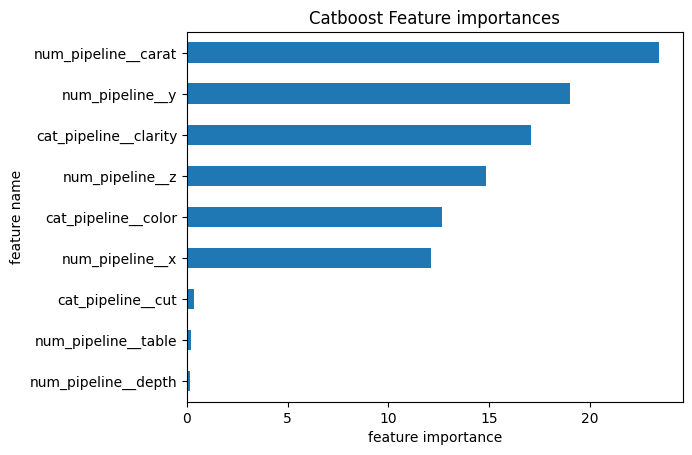

In [24]:
# Lets get the feature importance based on catboost regressor.

feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature importances')
plt.show()